In [2]:
#allows any changes on external files to be loaded on code run.
%load_ext autoreload
%autoreload 2

# Generating Data on LUMI

In [3]:
from GENE_ML.gene_ml.samplers.uniform import Uniform
from GENE_ML.gene_ml.executors.ScanExecutor import ScanExecutor
from GENE_ML.gene_ml.runners.GENErunner import GENErunner
from GENE_ML.gene_ml.parsers.GENEparser import GENE_scan_parser

import os
import sys
sys.path.append(os.path.join(os.getcwd(),'GENE_ML','enchanted-surrogates','src'))


parameters = ['_grp_species_1-omt', '_grp_species_0-omt']
bounds = [(4,6.7), (2.1,3.5)] #if bounds is a float rather than tuple then the sampler will make that the only value

#Working fine
# parameters = ['box-kymin', '_grp_species_1-omt', 'species-omn']
# bounds = [(0.05,1), (10,70), (5,60)]

num_samples = 5
sampler = Uniform(parameters=parameters, bounds=bounds, num_samples=num_samples)

##Parser
#The parsers main function is write_input_file
# wite_input_file takes a parameters file from base_params_path and a set of points in the form of a dict {param1:[point1,point2...], param2:[point1,point2...]...} 
#  It will then create a parameters file that can scan over all the points.
base_params_path = os.path.join(os.getcwd(),'parameters_base_uq')
remote_save_dir='/scratch/project_462000451/gene_out/gene_auto/test'
parser = GENE_scan_parser(base_params_path, remote_save_dir)

## Runner
#The Runner is responsible for actually running a parameters file on lumi. Its main function is code_run.
# code_run will take the set of points named samples and parse them into a parameters file.
#  It then uses ssh to run GENE with this parametres file and a passed sbatch script.
remote_run_dir = '/project/project_462000451/gene_auto/'
host = 'lumi' #needs to be configured in /home/<user>/.ssh/config
sbatch_base_path = os.path.join('sbatch_base')
guess_sample_wallseconds = 81 # a guess for the number of seconds it takes to run one sample.
runner = GENErunner(parser, remote_run_dir, host, sbatch_base_path, guess_sample_wallseconds)

##Executor
#The executor will divide the samples into batches; one for each worker. Each batch will be ran in paralell in seperate sbatch jobs. 
# The executor should alter a base batch script to account for that less samples will be ran. 
num_workers = 1
executor = ScanExecutor(num_workers, sampler, runner)

In [4]:
#executor.start_runs()

# Pulling Data from LUMI

The data loaded was created by scanning over ion and electron temperature gradients within their margin of uncertainty. 

In [5]:
from GENE_ML.gene_ml.dataset.ScanData import ScanData
from GENE_ML.gene_ml.parsers.GENEparser import GENE_scan_parser

parser = GENE_scan_parser()

host = 'lumi'
#data_name = f'{num_samples}s_{len(parameters)}p_uq'#'1000s_2p_uq'
data_name = '1000s_3p_uq'
test_percentage=50
# data_set = ScanData(data_name, parser, host, remote_path=remote_save_dir, test_percentage=test_percentage)

#If the data is already loaded from the remote to local .../scanlogs/<data_name> then the host and remote path can be ommitted
data_set = ScanData(data_name, parser, test_percentage=test_percentage)

data_set.remove_parameter('kymin1')
data_set.df

Initialising dataset

LOADING SCANLOG/S


LOADING SCANLOG INTO PYTHON /home/djdaniel/GENE_UQ/scanlogs/1000s_3p_uq/scan___6.log


LOADING SCANLOG INTO PYTHON /home/djdaniel/GENE_UQ/scanlogs/1000s_3p_uq/scan___5.log


LOADING SCANLOG INTO PYTHON /home/djdaniel/GENE_UQ/scanlogs/1000s_3p_uq/scan___8.log


LOADING SCANLOG INTO PYTHON /home/djdaniel/GENE_UQ/scanlogs/1000s_3p_uq/scan___9.log


LOADING SCANLOG INTO PYTHON /home/djdaniel/GENE_UQ/scanlogs/1000s_3p_uq/scan___7.log


LOADING SCANLOG INTO PYTHON /home/djdaniel/GENE_UQ/scanlogs/1000s_3p_uq/scan___4.log


LOADING SCANLOG INTO PYTHON /home/djdaniel/GENE_UQ/scanlogs/1000s_3p_uq/scan___0.log


LOADING SCANLOG INTO PYTHON /home/djdaniel/GENE_UQ/scanlogs/1000s_3p_uq/scan___2.log


LOADING SCANLOG INTO PYTHON /home/djdaniel/GENE_UQ/scanlogs/1000s_3p_uq/scan___1.log


LOADING SCANLOG INTO PYTHON /home/djdaniel/GENE_UQ/scanlogs/1000s_3p_uq/scan___3.log

491 SAMPLES RAN OUT OF 1000 BEFORE MAX WALLTIME:
NUMBER OF SAMPLES AFTER REMOVING NaN's: 

,omt2,omt1,growthrate,frequency
0,4.742492,2.346237,0.0310,0.0190
1,5.609349,2.772740,0.0450,0.0200
2,5.835770,2.112637,0.0430,-0.1270
3,5.461989,3.454682,0.0690,0.0260
4,5.088760,2.980634,0.0540,0.0230
...,...,...,...,...
94,5.474297,2.865653,0.0490,0.0210
95,4.731344,2.640813,0.0420,0.0220
96,4.049889,3.253409,0.0650,0.0310
97,5.267241,2.967284,0.0530,0.0230


# Training Surrogate Model 

In [6]:
import os
from GENE_ML.gene_ml.models.GPR import GPR
from GENE_ML.gene_ml.results.results import Results

#numsamples_numparameters_model_testpercentage
model_name = 'GPR'
results_gpr_name = 'uq_results_1000s_2p_GPR_50tp'
#results_gpr_name = f'uq_results_{num_samples}s_{len(parameters)}p_{model_name}_{test_percentage}tp' #
results_gpr = Results(results_gpr_name)
gpr = GPR(name = model_name)
print(gpr.parent)
if os.path.exists(results_gpr.path) and os.path.exists(gpr.path):
    print('\nLOADING RESULTS FROM FILE\n')
    results_gpr = results_gpr.load()
    print(f'{results_gpr.name} IS LOADED')
    gpr = gpr.load()
else:
    print('\nCOMPUTING RESULTS\n')
    #Sampling already done, gene has been ran
    gpr.train(data_set.x_train, data_set.growthrate_train)
    gpr.tune_hypers(data_set.x_train, data_set.growthrate_train)

    results_gpr.growthrate_predict_seen, growthrate_predict_seen_errors = gpr.predict(data_set.x_train)
    results_gpr.growthrate_predict_unseen, growthrate_predict_unseen_errors = gpr.predict(data_set.x_test)

    results_gpr.save()

parent

COMPUTING RESULTS

GPR is a parameterless approach and does not have a training step. Instead the hyperparameters are tuned to the data.
OPTIMISING THE HYPERPERS
CURRENT HYPERS:
 
Name : GP regression
Objective : 226.6818988684917
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |   (2,)  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        
OPTIMISING THE HYPERPERS:
Optimization restart 1/3, f = -1384.8643438900895
Optimization restart 2/3, f = -1384.8643438919366
Optimization restart 3/3, f = -1384.864343889915
RESULTING HYPERS:
 
Name : GP regression
Objective : -1384.8643438919366
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
 

NO UNCERTAINTY PROVIDED
MAX 0.072 0.07186096398433622
0.072
NO UNCERTAINTY PROVIDED
MAX 0.071 0.07123351849602005
0.07123351849602005


 /tmp/ipykernel_10511/540111191.py:20: UserWarning:FigureCanvasAgg is non-interactive, and thus cannot be shown


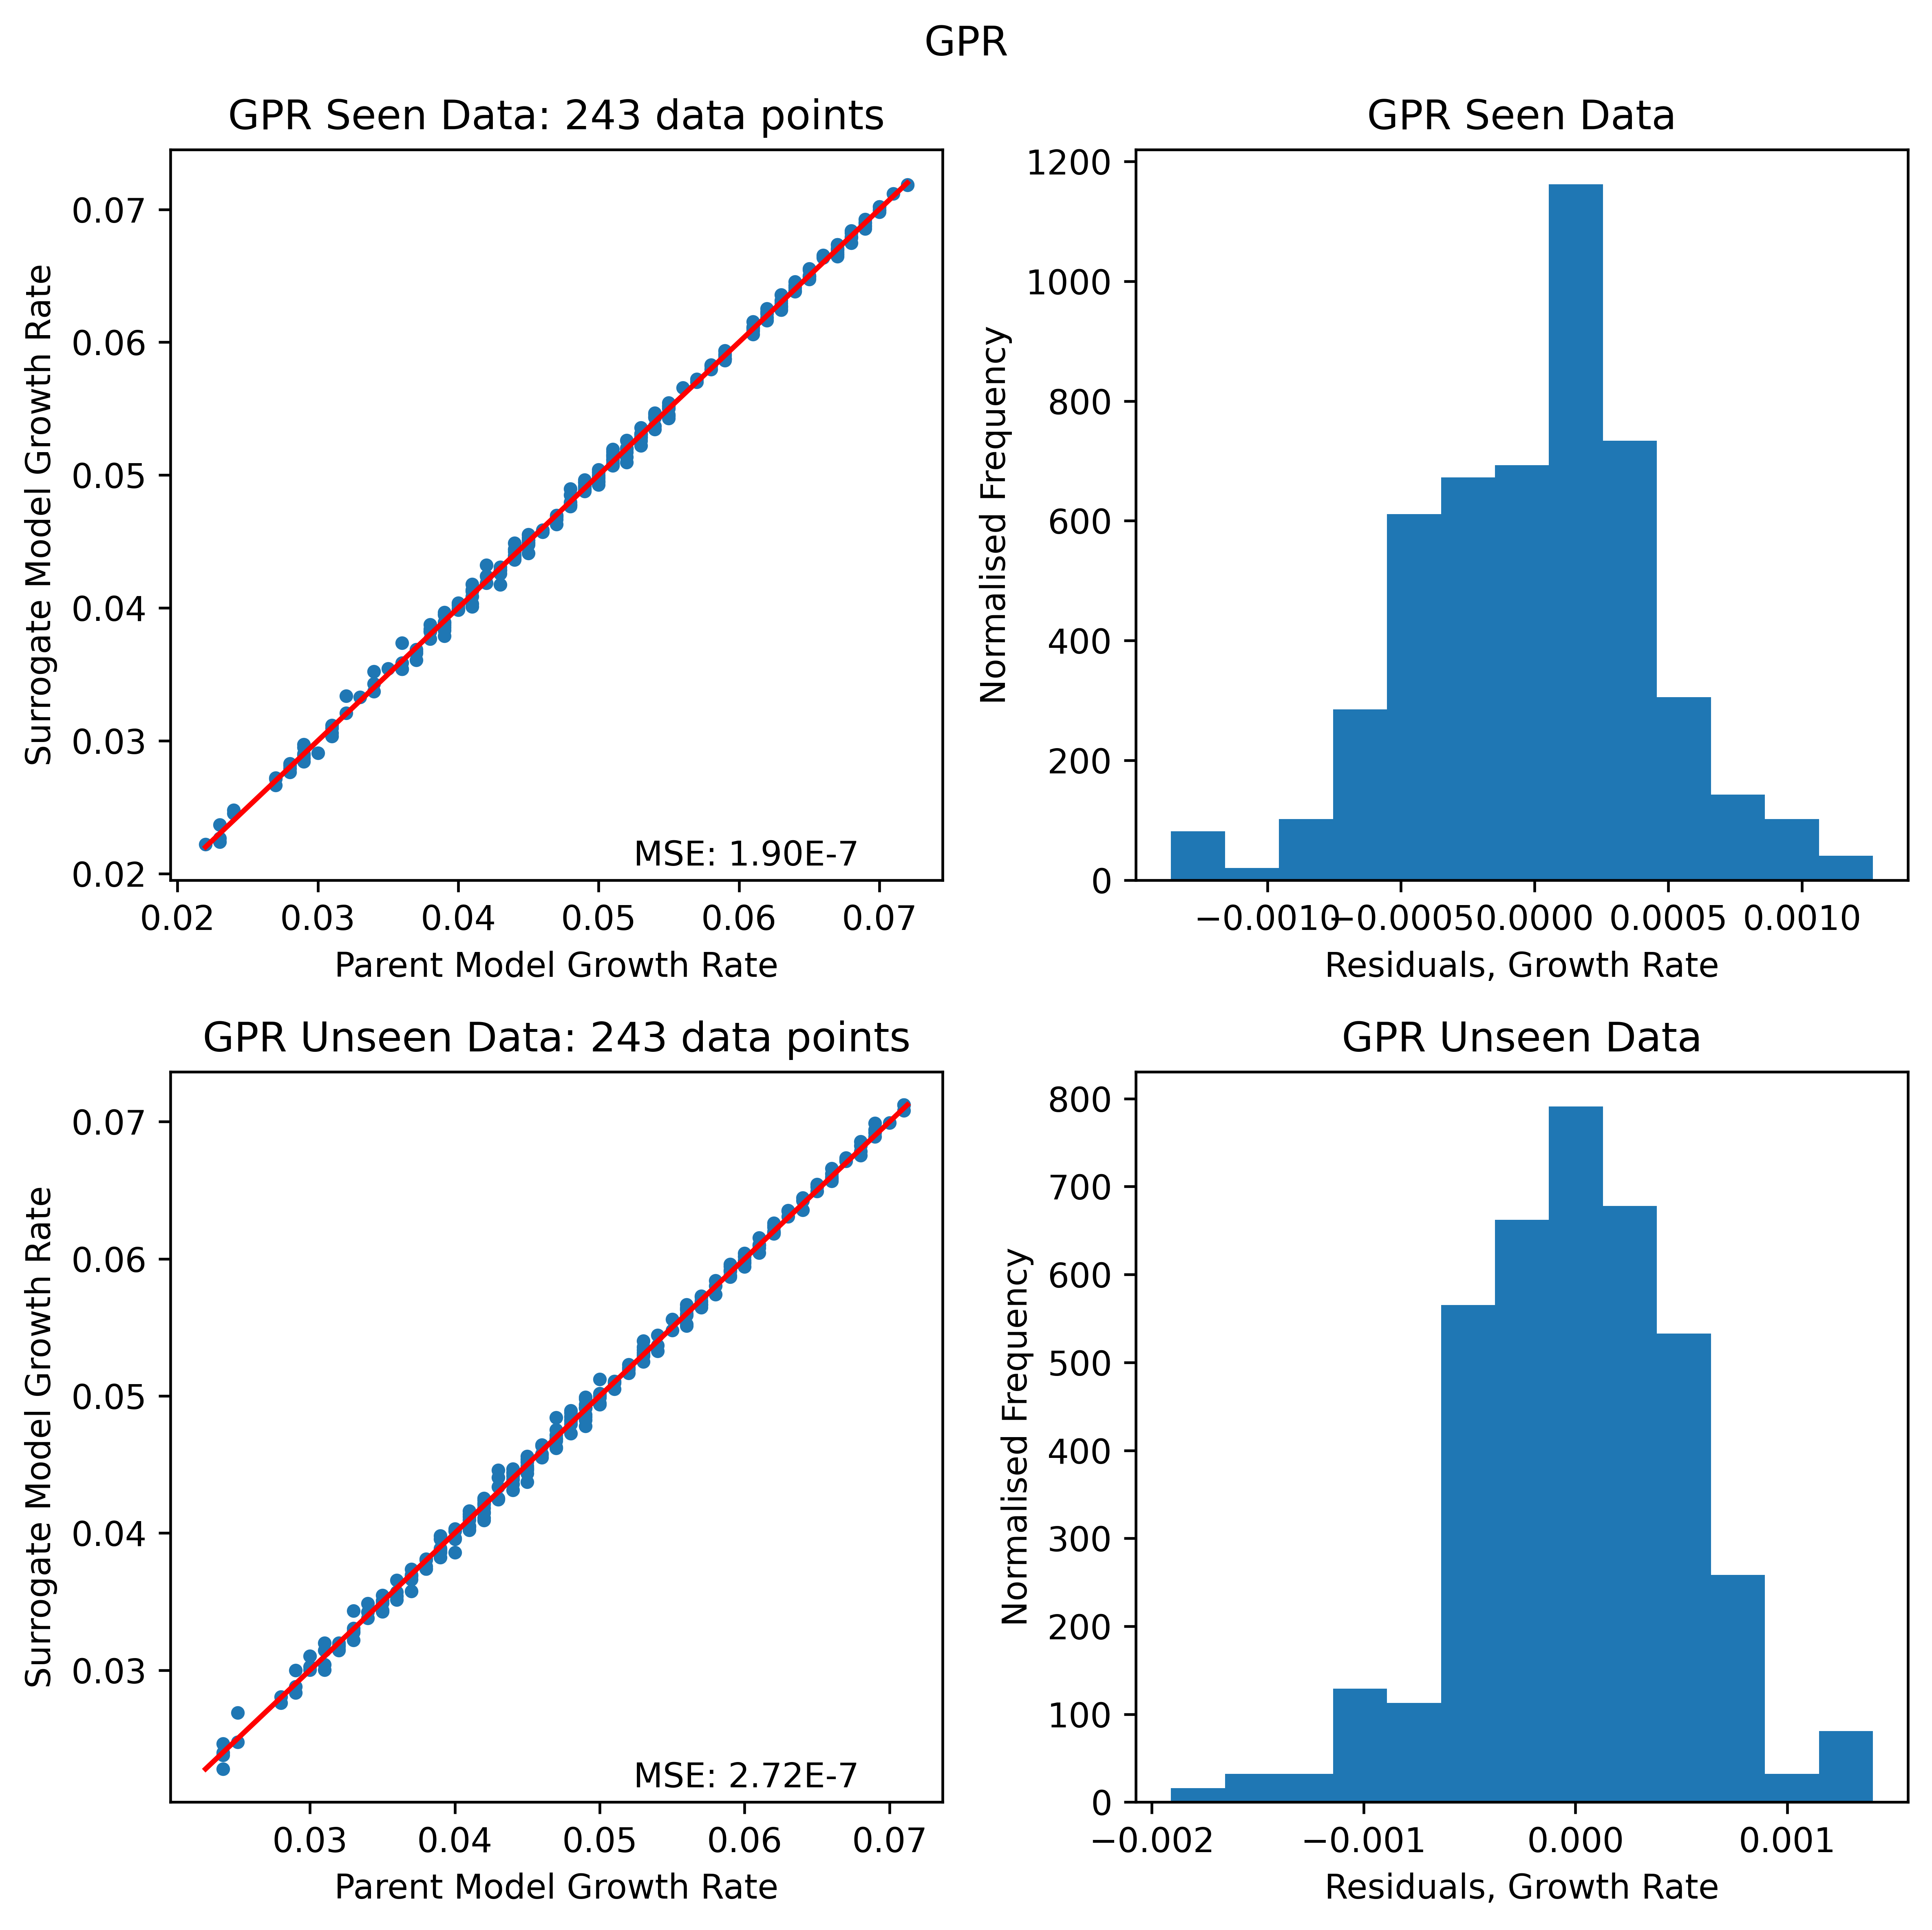

In [7]:
import matplotlib.pyplot as plt
from GENE_ML.gene_ml import visualise as vis

ncol=2
nrow=2
size=4
model_name = 'GPR'
fig_residuals, [[ax1,ax2],[ax3,ax4]] = plt.subplots(nrow,ncol, figsize=(size*ncol,size*nrow), dpi=600)
    
vis.residual_plot(ax1, fig_residuals, data_set.growthrate_train, results_gpr.growthrate_predict_seen, var_name='Growth Rate', title=f'{model_name} Seen Data')#, y_pred_err=growthrate_predict_seen_errors)
vis.residual_hist(ax2, fig_residuals, data_set.growthrate_train, results_gpr.growthrate_predict_seen, var_name='Growth Rate', title=f'{model_name} Seen Data', bins=13)

vis.residual_plot(ax3, fig_residuals, data_set.growthrate_test, results_gpr.growthrate_predict_unseen, var_name='Growth Rate', title=f'{model_name} Unseen Data')#, y_pred_err=growthrate_predict_unseen_errors)
vis.residual_hist(ax4, fig_residuals, data_set.growthrate_test, results_gpr.growthrate_predict_unseen, var_name='Growth Rate', title=f'{model_name} Unseen Data', bins=13)

# ax4.sharex(ax2)

fig_residuals.suptitle(model_name)
fig_residuals.tight_layout()
fig_residuals.show()

In [33]:
import numpy as np
from GENE_ML.gene_ml.samplers.gaussian import Gaussian

num_samples_g = 100000
gaussian = Gaussian(bounds, num_samples_g, parameters)

gaussian.samples_np

array([[4.80623344, 2.50723587],
       [4.68385044, 2.87420084],
       [5.57583114, 2.37410619],
       ...,
       [5.09055347, 2.94684222],
       [5.31674976, 2.37283913],
       [4.53815407, 2.68840375]])

In [34]:
print(gaussian.samples_np.shape)
print(data_set.x_train.shape)



(100000, 2)
(243, 2)


(100000, 1)
[[0.03672265]
 [0.05084211]
 [0.03403357]
 ...
 [0.05256407]
 [0.03157641]
 [0.0445026 ]]
[[4.656747 3.161537]
 [4.142848 3.328288]
 [4.39567  3.441717]
 [5.851016 2.526608]
 [5.346428 2.19731 ]
 [6.245883 2.208358]
 [4.539037 2.281065]
 [4.881863 2.822348]
 [4.052941 2.666556]
 [5.752202 3.437585]]
[0.062 0.067 0.071 0.038 0.031 0.048 0.029 0.049 0.045 0.069]
SHAPE (1, 2) (243, 2)
(1, 1)
[[0.04697029]]
(1, 1)
[[0.02328608]]
(1, 1)
[[0.06827137]]


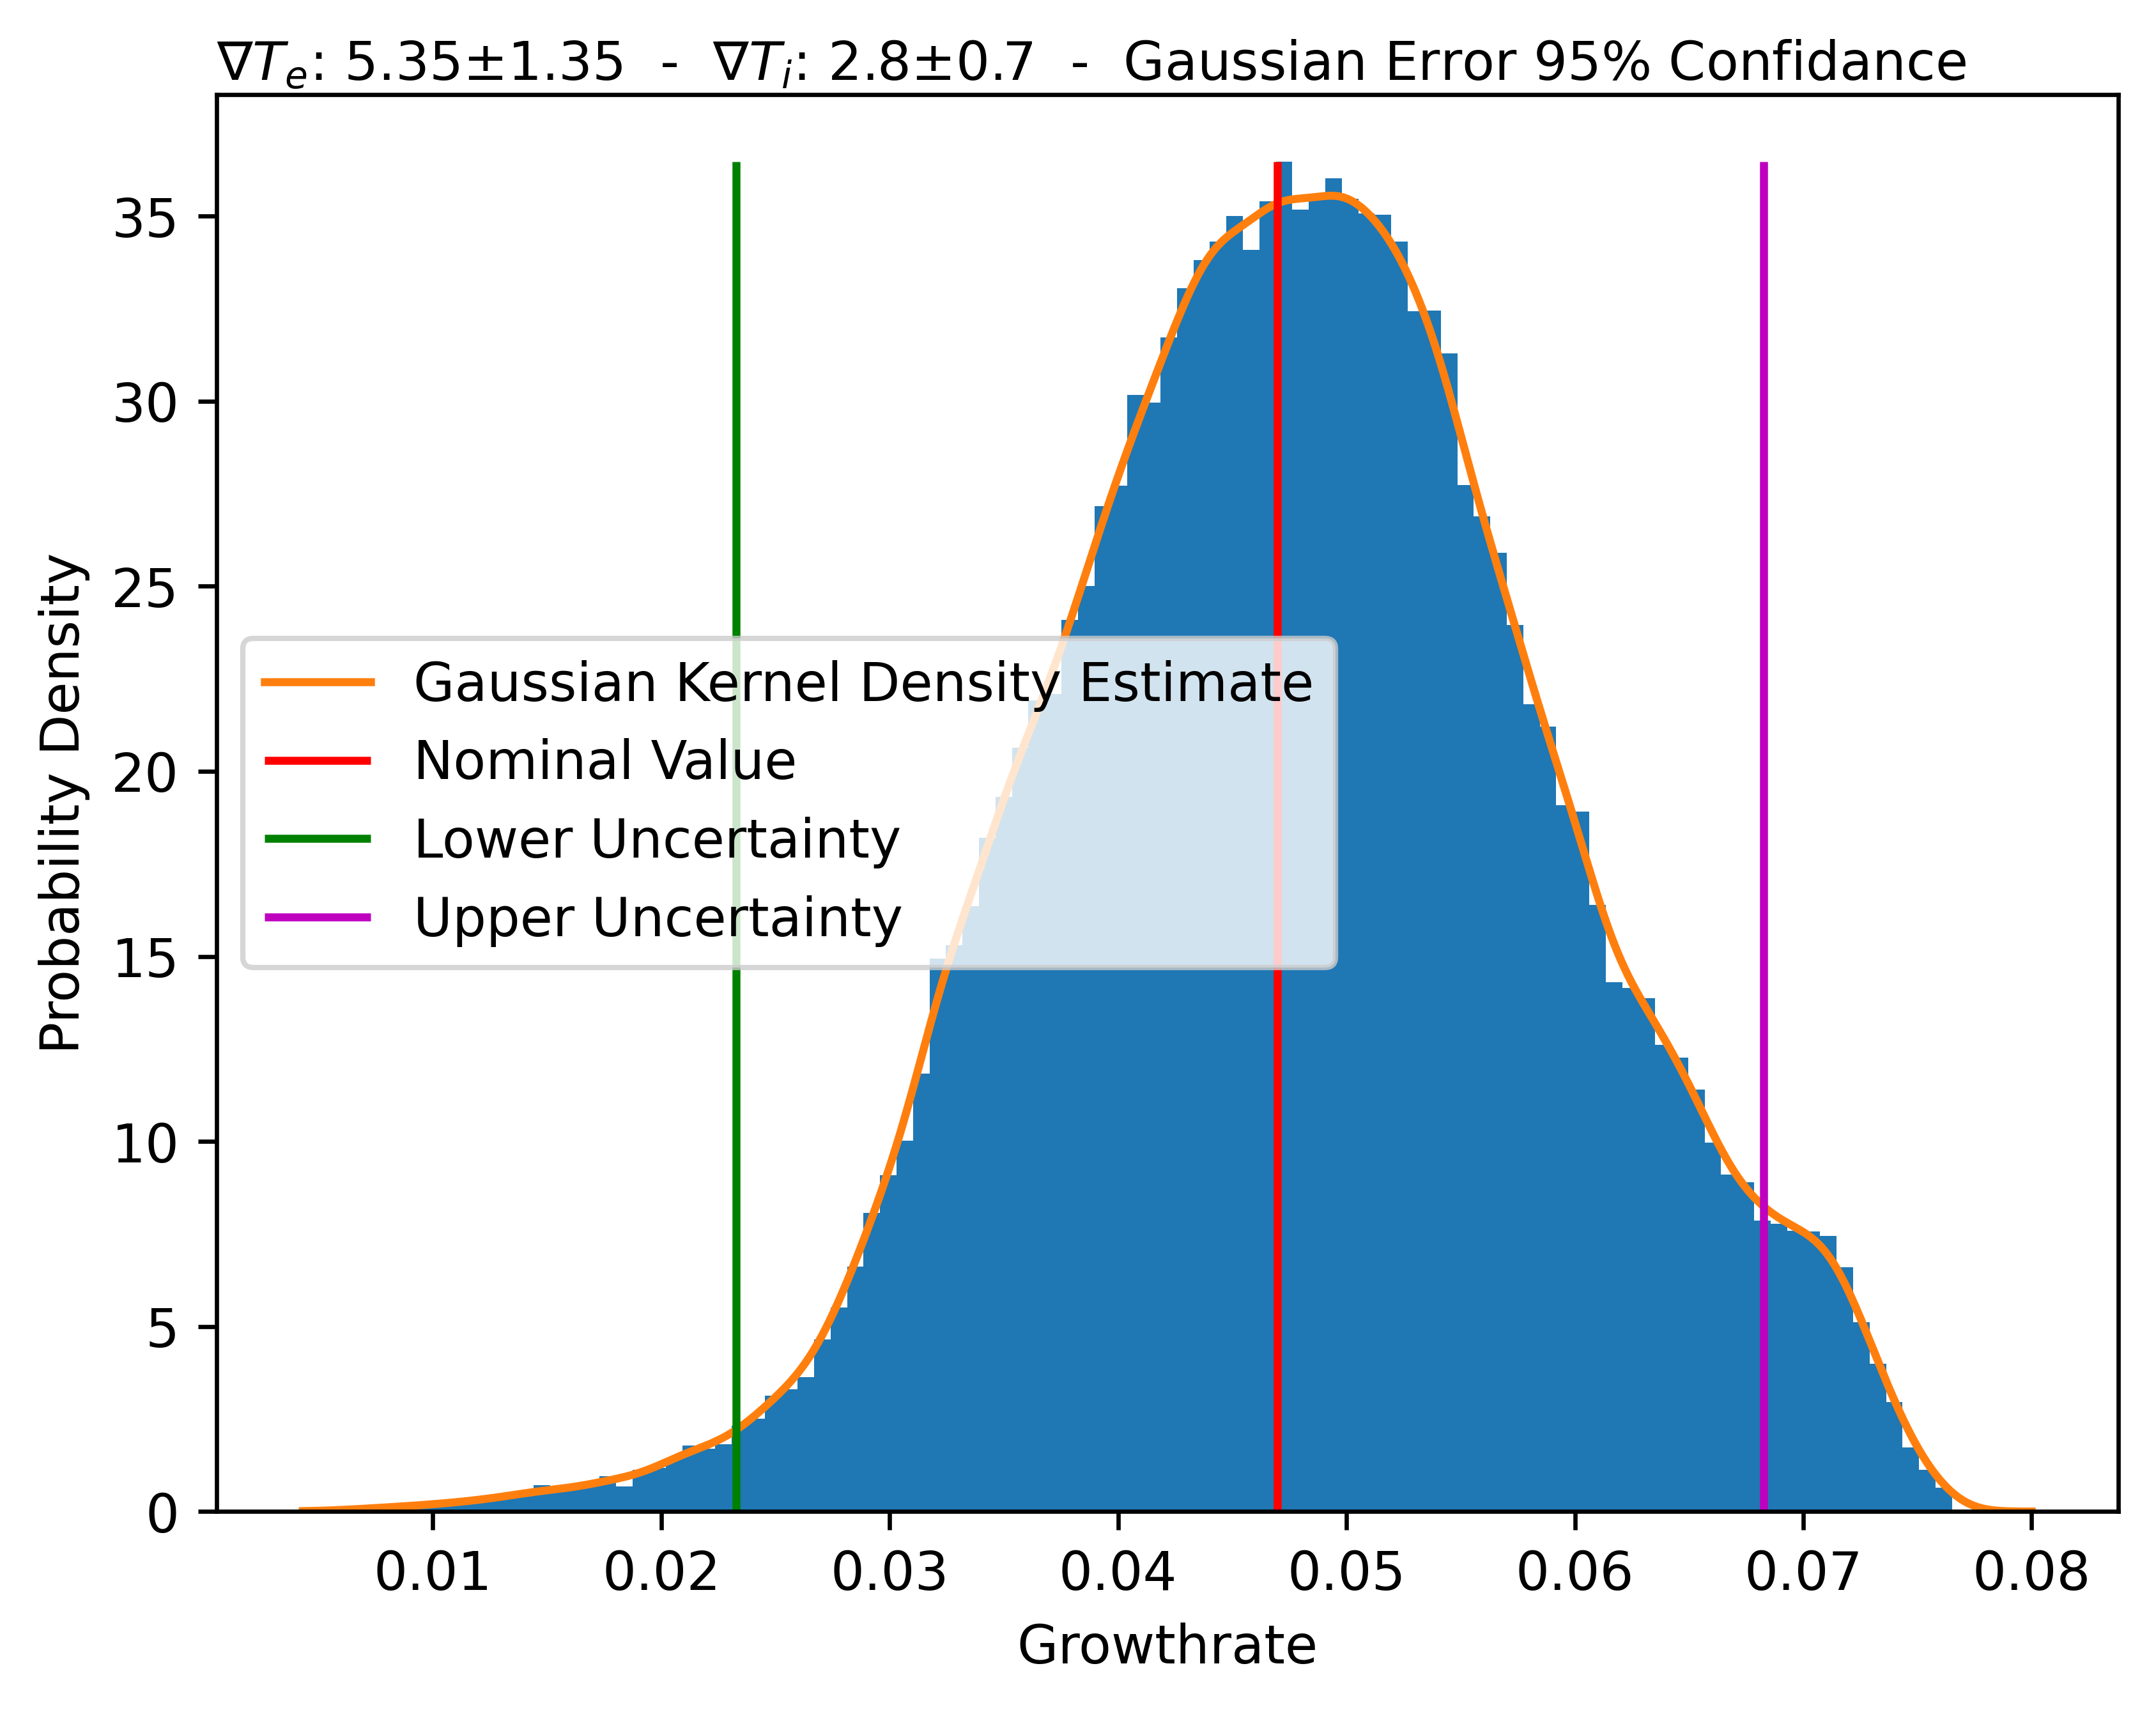

In [41]:
from scipy import stats
growthrates, _ = gpr.predict(gaussian.samples_np)
print(data_set.x_train[0:10])
print(data_set.growthrate_train[0:10])

bounds = [(4,6.7), (2.1,3.5)]
nominal_parameters = np.array([np.mean(b) for b in bounds]).reshape((2,1)).T
print('SHAPE', nominal_parameters.shape, data_set.x_train.shape)
nominal_growthrate, _ = gpr.predict(nominal_parameters)
left_bound_gr, _ = gpr.predict(np.array([b[0] for b in bounds]).reshape(2,1).T)
right_bound_gr, _ = gpr.predict(np.array([b[1] for b in bounds]).reshape(2,1).T)

fig = plt.figure(dpi=600)
kde = stats.gaussian_kde(growthrates)
hist_x = np.linspace(np.min(growthrates),0.08, 1000)
n, bins, _ = plt.hist(growthrates, bins=100, density=True)
plt.plot(hist_x, kde(hist_x), label='Gaussian Kernel Density Estimate')
plt.xlabel('Growthrate')
plt.ylabel('Probability Density')
plt.vlines(nominal_growthrate, 0, max(n), 'r', label='Nominal Value')
plt.vlines(left_bound_gr, 0, max(n), 'g', label='Lower Uncertainty')
plt.vlines(right_bound_gr, 0, max(n), 'm', label='Upper Uncertainty')
plt.annotate(fr'$\nabla T_e$: {nominal_parameters[0][0]}$\pm$1.35  -  $\nabla T_i$: {nominal_parameters[0][1]}$\pm$0.7  -  Gaussian Error 95% Confidance',
            xy=(0, 1.01), xycoords='axes fraction',fontsize=10)

plt.legend()
plt.show()


In [167]:
import numpy as np
from GENE_ML.gene_ml.samplers.uniform import Uniform

num_samples_u = 100000
uniform = Uniform(bounds, num_samples_u, parameters[1:])

uniform.samples_np.shape

(100000, 2)

[[4.656747 3.161537]
 [4.142848 3.328288]
 [4.39567  3.441717]
 [5.851016 2.526608]
 [5.346428 2.19731 ]
 [6.245883 2.208358]
 [4.539037 2.281065]
 [4.881863 2.822348]
 [4.052941 2.666556]
 [5.752202 3.437585]]
[0.062 0.067 0.071 0.038 0.031 0.048 0.029 0.049 0.045 0.069]
SHAPE (1, 2) (243, 2)


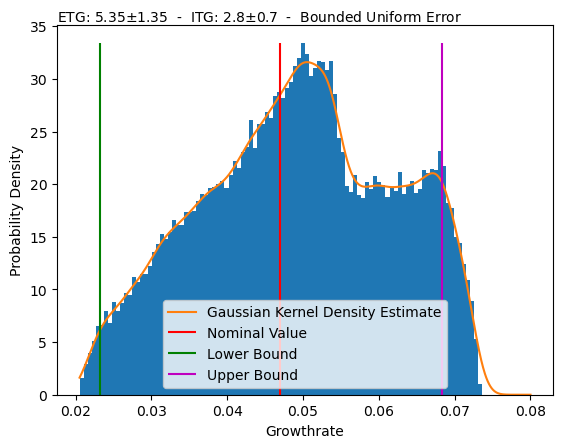

In [172]:
from scipy import stats
growthrates, _ = gpr.predict(uniform.samples_np)
print(data_set.x_train[0:10])
print(data_set.growthrate_train[0:10])

bounds = [(4,6.7), (2.1,3.5)]
nominal_parameters = np.array([np.mean(b) for b in bounds]).reshape((2,1)).T
print('SHAPE', nominal_parameters.shape, data_set.x_train.shape)
nominal_growthrate, _ = gpr.predict(nominal_parameters)
left_bound_gr, _ = gpr.predict(np.array([b[0] for b in bounds]).reshape(2,1).T)
right_bound_gr, _ = gpr.predict(np.array([b[1] for b in bounds]).reshape(2,1).T)

kde = stats.gaussian_kde(growthrates)
hist_x = np.linspace(np.min(growthrates),0.08, 1000)
n, bins, _ = plt.hist(growthrates, bins=100, density=True)
plt.plot(hist_x, kde(hist_x), label='Gaussian Kernel Density Estimate')
plt.xlabel('Growthrate')
plt.ylabel('Probability Density')
plt.vlines(nominal_growthrate, 0, max(n), 'r', label='Nominal Value')
plt.vlines(left_bound_gr, 0, max(n), 'g', label='Lower Bound')
plt.vlines(right_bound_gr, 0, max(n), 'm', label='Upper Bound')
plt.annotate(f'ETG: {nominal_parameters[0][0]}$\pm$1.35  -  ITG: {nominal_parameters[0][1]}$\pm$0.7  -  Bounded Uniform Error',
            xy=(0, 1.01), xycoords='axes fraction',fontsize=10)

plt.legend()
plt.show()

